# Real-Time American Sign Language Detection and Speech Synthesis

This notebook implements a real-time Word-Level American Sign Language detection system with speech output. The system will:

1. Capture video input from the webcam
2. Detect hand gestures and classify them as ASL signs
3. Convert recognized signs to text
4. Synthesize speech from the recognized text

This implementation uses a modular approach with code organized into the following modules:

- `mediapipe_utils.py`: MediaPipe detection and landmark utilities
- `data_processing.py`: Dataset creation and handling
- `model_utils.py`: Model training and evaluation
- `realtime_asl.py`: Real-time detection functionality
- `sign_model_builder.py`: LSTM model architecture

Let's get started by installing the necessary dependencies.

In [ ]:
# Install requirements anually d run the script
!pip install -r requirements.txt

## Import Libraries

We'll import the necessary libraries and modules for our application.

In [2]:

import mediapipe as mp
import os
import pyttsx3
import torch
from module.helper_functions import plot_loss_curves

# Import our modular components
import sys
sys.path.append('./module')
from module.mediapipe_utils import setup_holistic_model
from module.data_processing import collect_sign_data, organize_data_for_testing, create_separate_dataloaders
from module.model_utils import train, save_model
from module.realtime_asl import ASLDetector
from module.sign_model_builder import LSTM_Sign_Model

# Initialize MediaPipe solutions (for backward compatibility with existing code)
mp_holistic = mp.solutions.holistic

## MediaPipe Setup

We're using the modular implementation from `mediapipe_utils.py` for hand tracking and landmark detection.

In [17]:
# Initialize MediaPipe solutions for visualization if needed
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

# We're using the modular implementation for these functions:
# - mediapipe_detection from module.mediapipe_utils
# - draw_landmarks from module.mediapipe_utils
# - extract_keypoints from module.mediapipe_utils
# - setup_holistic_model from module.mediapipe_utils

## Keypoint Extraction

We're using the keypoint extraction functionality from our `module.mediapipe_utils` module, which extracts useful data from MediaPipe detections for our model.

In [4]:
# Using extract_keypoints from module.mediapipe_utils, which:
# 1. Extracts pose landmarks (33 points with x, y, z, visibility)
# 2. Extracts face landmarks (468 points with x, y, z)
# 3. Extracts left hand landmarks (21 points with x, y, z) 
# 4. Extracts right hand landmarks (21 points with x, y, z)
# 5. Concatenates all points into a single feature vector

# This gives us a feature vector of length 1662:

## Explore the Dataset

Let's explore the available data to understand what we're working with.

In [18]:
# List the available signs in our dataset
data_path = os.path.join('data')
actions = os.listdir(data_path)
# Remove any hidden files (like .DS_Store)
actions = [action for action in actions if not action.startswith('.')]

print(f"Available signs: {actions}")

# Get some stats about the dataset
sign_folders = os.listdir(os.path.join(data_path, actions[0]))
num_sequences = len(sign_folders)
sequence_length = len(os.listdir(os.path.join(data_path, actions[0], '0')))

print(f"Number of sequences per sign: {num_sequences}")
print(f"Frames per sequence: {sequence_length}")

Available signs: ['thanks', 'hello', 'whatsup', 'iloveyou']
Number of sequences per sign: 30
Frames per sequence: 3


## Load or Build the PyTorch Model

We'll either load a pre-trained model from disk or build a new PyTorch model for sign language detection.

In [5]:
# # Check if we have a pre-trained model
# try:
#     model = torch.load('model/sign_language_model.pth')
#     print("Loaded pre-trained model from disk.")
    
#     # Get the list of actions from the saved model
#     data_path = os.path.join('data')
#     actions = os.listdir(data_path)
#     # Remove any hidden files (like .DS_Store)
#     actions = [action for action in actions if not action.startswith('.')]
    
# except:
#     print("Building a new model...")
    
#     # List the available signs in our dataset
#     data_path = os.path.join('data')
#     actions = os.listdir(data_path)
#     # Remove any hidden files (like .DS_Store)
#     actions = [action for action in actions if not action.startswith('.')]
    
#     # Define model parameters
#     input_size = 1662  # Number of features in keypoints
#     hidden_size = 64
#     num_layers = 1
#     num_classes = len(actions)
    
#     # Initialize model using our modular approach
#     model = LSTM_Sign_Model(
#         input_size=input_size, 
#         hidden_size=hidden_size, 
#         num_layers=num_layers, 
#         num_classes=num_classes
#     )
    
#     # Create a directory for saving the model if it doesn't exist
#     os.makedirs('model', exist_ok=True)
    
# If CUDA is available, move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

print(f"Model is using device: {device}")

Model is using device: cpu


## Set Up Text-to-Speech Engine

We'll use pyttsx3 for speech synthesis to convert detected signs to spoken words.

In [10]:
# Initialize the text-to-speech engine
engine = pyttsx3.init()

def speak(text):
    """Convert text to speech."""
    engine.say(text)
    engine.runAndWait()

## Data Collection Function

We'll use the modular function from `module.data_processing` to collect sign language data. This will help us build a custom dataset with our own gestures.

In [29]:
# Note: We're using the modular implementation from module.data_processing
# collect_sign_data(sign_name, holistic_model, num_sequences=30, sequence_length=30, camera_idx=0)

## Use the Data Collection Function

Run the cell below to collect data for a new sign. Follow these steps:
1. Enter the name of the sign you want to collect data for (e.g., 'thankyou', 'yes', 'no')
2. When the webcam starts, position yourself in front of the camera
3. After the 5-second countdown, perform the sign at a natural pace
4. Repeat for all sequences (default: 30)

To ensure good data quality:
- Maintain good lighting
- Keep a consistent background
- Try to perform the sign consistently each time
- Vary your position slightly between sequences for better model generalization

In [3]:
# Run this cell to collect data for a new sign
new_sign = input("Enter the name of the sign you want to collect data for: ")
num_seq = int(input("Enter the number of sequences to collect (default: 30): ") or 30)
seq_length = int(input("Enter the number of frames per sequence (default: 30): ") or 30)

print(f"\nPreparing to collect data for sign: '{new_sign}'")
print("Position yourself in front of the camera.")
print("Press Enter to start...")
input()

# Create holistic model for data collection
with setup_holistic_model() as holistic:
    collect_sign_data(new_sign, holistic, num_seq, seq_length, 2)

# Update the actions list
if os.path.exists('data'):
    actions = [action for action in os.listdir('data') if not action.startswith('.')]
    print(f"Updated available signs: {actions}")


Preparing to collect data for sign: 'hello'
Position yourself in front of the camera.
Press Enter to start...


I0000 00:00:1744811731.161880 1349022 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M1
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1744811731.268412 2718229 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744811731.287018 2718227 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744811731.290139 2718234 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744811731.290853 2718231 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744811731.291234 2718233 inference_feedback_manager.cc:114] Feedback manager requires a mod

Sequence 1 complete. Prepare for next sequence...
Sequence 2 complete. Prepare for next sequence...
Sequence 3 complete. Prepare for next sequence...
Sequence 4 complete. Prepare for next sequence...
Sequence 5 complete. Prepare for next sequence...
Sequence 6 complete. Prepare for next sequence...
Sequence 7 complete. Prepare for next sequence...
Sequence 8 complete. Prepare for next sequence...
Sequence 9 complete. Prepare for next sequence...
Sequence 10 complete. Prepare for next sequence...
Sequence 11 complete. Prepare for next sequence...
Sequence 12 complete. Prepare for next sequence...
Sequence 13 complete. Prepare for next sequence...
Sequence 14 complete. Prepare for next sequence...
Sequence 15 complete. Prepare for next sequence...
Sequence 16 complete. Prepare for next sequence...
Sequence 17 complete. Prepare for next sequence...
Sequence 18 complete. Prepare for next sequence...
Sequence 19 complete. Prepare for next sequence...
Sequence 20 complete. Prepare for next s

## Train with Separate Training and Testing Data

If you have separate datasets for training and testing, you can use the following function to train your model using both datasets.

In [6]:
import sys
sys.path.append('./module')
from module.mediapipe_utils import setup_holistic_model
from module.data_processing import collect_sign_data, organize_data_for_testing, create_separate_dataloaders, create_dataloaders
from module.model_utils import train, save_model, plot_loss_curves
from module.realtime_asl import ASLDetector
from module.sign_model_builder import LSTM_Sign_Model
organize_data_for_testing(train_split=0.7)

Data organized into data_train and data_test directories
Training data: 70%, Testing data: 30%


In [7]:
# Create new dataloaders with our fixed implementation
train_dir = "data_train"
test_dir = "data_test"
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    batch_size=BATCH_SIZE,
)

# Check if dataloaders are empty or have issues
print(f"Train dataloader length: {len(train_dataloader)}")
print(f"Test dataloader length: {len(test_dataloader)}")

# Check first batch in each dataloader
for batch_idx, (data, target) in enumerate(train_dataloader):
    print(f"Train batch {batch_idx}: data shape = {data.shape}, target shape = {target.shape}")
    break  # Just check the first batch
    
for batch_idx, (data, target) in enumerate(test_dataloader):
    print(f"Test batch {batch_idx}: data shape = {data.shape}, target shape = {target.shape}")
    break  # Just check the first batch
    
# Update the model for the correct number of classes
NUM_EPOCHS = 5
HIDDEN_UNITS = 10
LEARNING_RATE = 0.001
INPUT_SIZE = 1662

# Initialize model using our modular structure
model = LSTM_Sign_Model(
    input_size=INPUT_SIZE, 
    hidden_size=HIDDEN_UNITS,
    num_layers=1,  # Setting num_layers to 1 instead of NUM_EPOCHS which was incorrect
    num_classes=len(class_names) 
)
        
# Make sure model is on the right device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

Train dataloader length: 1
Test dataloader length: 1
Train batch 0: data shape = torch.Size([26, 30, 1662]), target shape = torch.Size([26])
Test batch 0: data shape = torch.Size([14, 30, 1662]), target shape = torch.Size([14])


 60%|██████    | 3/5 [00:00<00:00, 11.92it/s]

Epoch: 1 | train_loss: 0.0000 | train_acc: 1.0000 | test_loss: 0.0000 | test_acc: 1.0000
Epoch: 2 | train_loss: 0.0000 | train_acc: 1.0000 | test_loss: 0.0000 | test_acc: 1.0000
Epoch: 3 | train_loss: 0.0000 | train_acc: 1.0000 | test_loss: 0.0000 | test_acc: 1.0000


100%|██████████| 5/5 [00:00<00:00, 12.06it/s]


Epoch: 4 | train_loss: 0.0000 | train_acc: 1.0000 | test_loss: 0.0000 | test_acc: 1.0000
Epoch: 5 | train_loss: 0.0000 | train_acc: 1.0000 | test_loss: 0.0000 | test_acc: 1.0000
Model saved as 'model/sign_language_model.pth'


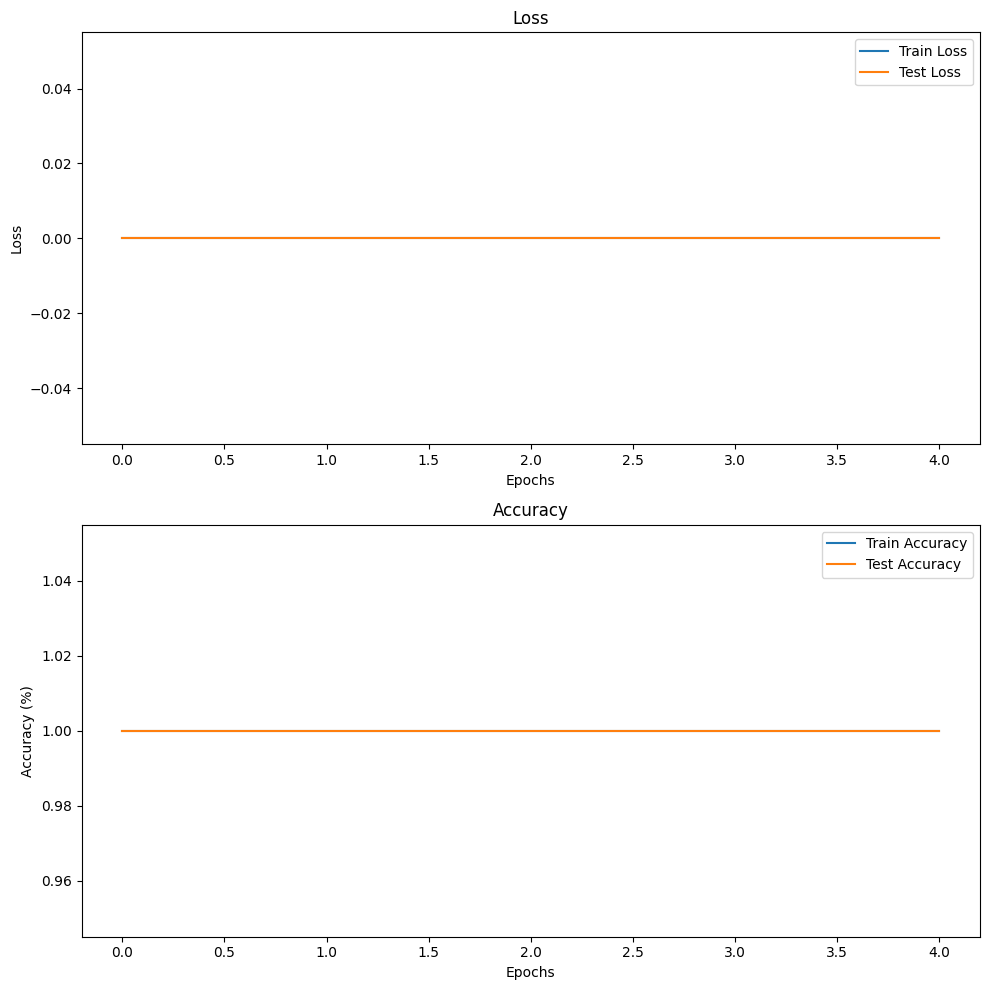

In [8]:
# Train the model with the corrected function call
results = train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=criterion,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    device=device
) 

# Save the model
save_model(
    model=model,
    path='model/sign_language_model.pth',
)


# Plot loss curves
plot_loss_curves(results)


## Real-Time Detection with PyTorch

Now, let's implement the real-time detection using our PyTorch model and the modular ASLDetector class.

In [ ]:
# Create a detector instance using our modular implementation
detector = ASLDetector(model_path='model/sign_language_model.pth', 
                      threshold=0.7,
                      sequence_length=30, 
                      device=device)

# Start real-time detection
detector.detect_in_realtime(camera_idx=2)

Model loaded with weights_only=False for backward compatibility
Loaded model from model/sign_language_model.pth
Detected actions: ['hello']


I0000 00:00:1744812434.703586 1349022 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M1
W0000 00:00:1744812434.781159 2735331 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744812434.793868 2735331 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744812434.796884 2735335 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744812434.797053 2735336 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1744812434.798564 2735332 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support 

KeyboardInterrupt: 

## Future Improvements

Here are some potential improvements for the application:

1. **Sentence Formation**: Implement grammar rules to form proper sentences from detected signs.
2. **Continuous Sign Language Recognition**: Improve the model to handle continuous signing.
3. **User Interface**: Create a more user-friendly interface with settings for sensitivity and speech voice.
4. **Mobile Application**: Convert the system to a mobile application for wider accessibility.
5. **Expanded Vocabulary**: Train the model on a larger dataset to recognize more signs.
6. **Two-Way Translation**: Add speech-to-sign functionality for two-way communication.

## Conclusion

This notebook demonstrates a real-time American Sign Language detection and speech synthesis system. The application uses:

1. MediaPipe for hand tracking and landmark detection
2. PyTorch for sign classification using an LSTM model
3. OpenCV for video capture and visualization
4. pyttsx3 for text-to-speech conversion

The system can detect Word-Level ASL signs and convert them to speech in real-time, providing a valuable tool for sign language communication.